Make sure you restart runtime after installing the libraries below.


In [1]:
## installing the required packages
!pip install librosa==0.9.2
!pip install transformers
!pip install unidecode
!pip install tensorflow_addons
!pip install multiprocess
!pip install kaldiio
!pip install webrtcvad
!pip install utils

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# mounting google drive for the session
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd /content/drive/MyDrive/DL_Final_Project/original_repo/

/content/drive/MyDrive/DL_Final_Project/original_repo


You will only need to change the `repo_path` below so that it points to the folder that contains source code from the repo


In [4]:
# IMPORTS
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel
import librosa

from synthesizer.inference import Synthesizer
from synthesizer_like_translator.inference import Synthesizer as Translator
from synthesizer.kaldi_interface import KaldiInterface
from encoder import inference as encoder_speaker
from encoder import inference_accent as encoder_accent
from vocoder import inference as vocoder
import numpy as np
from pathlib import Path
from utils.argutils import print_args
import random
import IPython.display as ipd
import os
from synthesizer.hparams import hparams

## paths set up ##

repo_path = '/content/drive/MyDrive/DL_Final_Project/original_repo/' ## CHANGE THIS

### SHOULDNT NEED TO CHANGE THESE ###
pretrained_models_path = os.path.join(repo_path, "pretrained_models/")
encoder_speaker_weights = Path(os.path.join(pretrained_models_path, "pretrained_model/pretrained/encoder/saved_models/pretrained.pt"))
encoder_accent_weights = Path(os.path.join(pretrained_models_path, "pretrained_model/pretrained/encoder/saved_models/encoder_accent.pt"))
vocoder_weights = Path(os.path.join(pretrained_models_path, "pretrained_model/pretrained/vocoder/saved_models/pretrained/pretrained.pt"))
syn_dir = Path(os.path.join(pretrained_models_path, "synthesizer/taco_pretrained"))
syn_dir_trans = Path(os.path.join(pretrained_models_path, "translator/logs-translator_train/taco_pretrained"))
### SHOULDNT NEED TO CHANGE THESE ###

## loading pretrained models for accent encoder and speaker coder
encoder_speaker.load_model(encoder_speaker_weights)
encoder_accent.load_model(encoder_accent_weights)
# synthesizer = Synthesizer(syn_dir)
# translator = Translator(syn_dir_trans)
# vocoder.load_model(vocoder_weights)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
Instructions for updating:
non-resource variables are not supported in the long term


Loaded encoder "pretrained.pt" trained to step 1564501
Loaded encoder "encoder_accent.pt" trained to step 90001


In [5]:

# def synthesize(bnf, embed):
#     spec = synthesizer.synthesize_spectrograms([bnf], [embed])[0]
#     # print(spec.shape)
#     generated_wav = vocoder.infer_waveform(spec)
#     generated_wav = np.pad(generated_wav, (0, synthesizer.sample_rate), mode="constant")
#     return generated_wav


# def translate_ppg(bnf, embed):
#     spec = translator.synthesize_spectrograms([bnf], [embed])[0]
#     return spec

# We will be using these functions that use the pretrained accent/speaker encoder to generate the accent/speaker embeddings
def generate_accent_embed(src_utterance_path):
    wav, _ = librosa.load(src_utterance_path, hparams.sample_rate)
    wav = encoder_speaker.preprocess_wav(wav)
    embed_accent = encoder_accent.embed_utterance(wav)

    return embed_accent

def generate_speaker_embed(tgt_utterance_path):
    wav, _ = librosa.load(tgt_utterance_path, hparams.sample_rate)
    wav = encoder_speaker.preprocess_wav(wav)
    embed_speaker = encoder_speaker.embed_utterance(wav)

    return embed_speaker

Example:

- Since we extracted the BNFs on a local machine, the scp files record the absolute paths to where the BNFs are. And obviously this will not work on google colab because now we have a completely different set of paths (I have tried to use relative paths on local machine but because of how the kaldi script work, it would not work)

- We will need to preprocess the scp files again so that they have google drive paths

- Run the functions below before loading their BNFs

In [6]:
def preprocess_wav_scp(speaker_path):
  """
    input example: /content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/BWC/
  """
  kaldi_dir = speaker_path+"kaldi/"
  scp_path = str(os.path.join(kaldi_dir, 'wav.scp'))
  new_scp_path =  str(os.path.join(kaldi_dir, 'wav_modified.scp'))
  print(scp_path)

  with open(scp_path, "r") as old_scp, open(new_scp_path, "w") as new_scp:
        for line in old_scp:
            print(line)
            parts = line.strip().split()
            if len(parts) != 2:
                print(f"Warning: Invalid line in {scp_path}: {line}")
                continue
            file_id, old_filepath = parts
            # old_filepath is like "/home/jb7410/ppg2ppg/speakers/L2_speakers/BWC/wav/arctic_a0011.wav"
            head, tail = os.path.split(old_filepath)  
            _, tail2 = os.path.split(head)
            keep_part = os.path.join(tail2, tail) 
            
            new_filepath = os.path.join(speaker_path, keep_part)
            new_scp.write(f"{file_id} {new_filepath}\n")
        print(f"Modified scp file saved at: {new_scp_path}")

def preprocess_feats_scp(speaker_path):
  """
    input example: /content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/BWC/
  """
  bnf_dir = speaker_path+"kaldi/bnf/"
  scp_path = str(os.path.join(bnf_dir, 'feats.scp'))
  new_scp_path =  str(os.path.join(bnf_dir, 'feats_modified.scp'))
  print(scp_path)

  with open(scp_path, "r") as old_scp, open(new_scp_path, "w") as new_scp:
      for line in old_scp:
          print(line)
          parts = line.strip().split()
          if len(parts) != 2:
              print(f"Warning: Invalid line in {scp_path}: {line}")
              continue
          file_id, old_filepath = parts
          # old_filepath is like "/home/jb7410/ppg2ppg/speakers/L2_speakers/BWC/kaldi/bnf/data/raw_bnfeat_kaldi.1.ark:4248913"
          _, tail = os.path.split(old_filepath)  

          new_filepath = os.path.join(bnf_dir+"data/", tail)
          print(new_filepath)
          new_scp.write(f"{file_id} {new_filepath}\n")
      print(f"Modified scp file saved at: {new_scp_path}")


def preprocess_both(speaker_path):
  preprocess_wav_scp(speaker_path)
  preprocess_feats_scp(speaker_path)

  return



In [7]:
## We are combining scp files into one big scp file so that it will be easier for us to load data when using the pytorch dataloader

def combine_feats(L2_speaker_path):
  combined_feats_path = os.path.join(L2_speaker_path, 'combined_feats.scp')
  
  # Ensure combined_feats.scp is empty before writing
  open(combined_feats_path, 'w').close()

  for speaker_id in os.listdir(L2_speaker_path):
      print(f"taking utterances from {speaker_id} now")
      speaker_feats_path = os.path.join(L2_speaker_path, speaker_id, 'kaldi', 'bnf', 'feats_modified.scp')
      
      if os.path.isfile(speaker_feats_path):
          with open(speaker_feats_path, 'r') as speaker_feats_file:
              lines = speaker_feats_file.readlines()
              
          with open(combined_feats_path, 'a') as combined_feats_file:
              combined_feats_file.writelines(lines)

def combine_wavs(L2_speaker_path):
    combined_feats_path = os.path.join(L2_speaker_path, 'combined_wav.scp')
  
    # Ensure combined_feats.scp is empty before writing
    open(combined_feats_path, 'w').close()

    for speaker_id in os.listdir(L2_speaker_path):
        print(f"taking utterances from {speaker_id} now")
        speaker_feats_path = os.path.join(L2_speaker_path, speaker_id, 'kaldi','wav_modified.scp')
        
        if os.path.isfile(speaker_feats_path):
            with open(speaker_feats_path, 'r') as speaker_feats_file:
                lines = speaker_feats_file.readlines()
                
            with open(combined_feats_path, 'a') as combined_feats_file:
                combined_feats_file.writelines(lines)

In [8]:
def gen_acc_embeds(combined_wav_scp_path, output_dir, embed_scp_path):
  """
    this function reads in all the L2 speakers' wav files (definied in the combined_wav.scp)
    generate accent embeddings for all of them
    and store the embeddings in the disk
  """
  if not os.path.exists(output_dir):
      os.makedirs(output_dir)

  with open(combined_wav_scp_path, 'r') as combined_wav_scp_file:
      lines = combined_wav_scp_file.readlines()

  with open(embed_scp_path, 'w') as embed_scp_file:
      for line in lines:
          scp_id, wav_file_path = line.strip().split()  # assuming the format is: "id path"

          # Check if the wav file exists
          if os.path.isfile(wav_file_path):
              accent_embed = generate_accent_embed(wav_file_path)
              output_path = os.path.join(output_dir, scp_id + '.npy')
              np.save(output_path, accent_embed)

              # Write the scp_id and corresponding embedding file path to the embeddings scp file
              embed_scp_file.write(f'{scp_id} {output_path}\n')

  print("Saved accent embeddings in '{}'.".format(output_dir))

In [9]:
## PRE-PROCESSING DATA:

# preprocess_feats_scp("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/BWC/")
# preprocess_wav_scp("/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/BDL/")
# preprocess_feats_scp("/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/BDL/")

# preprocess_both("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/ABA/")
# preprocess_both("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/EBVS/")
# preprocess_both("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/HQTV/")

# combine_feats("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/")
# combine_wavs("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/")
# gen_acc_embeds("/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/combined_wav.scp", "/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/acc_embeds", "/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/accent_embeds.scp")


In [10]:
## FUNCTION TO LOAD BNFS AND SEE IF THEY LOAD PROPERLY

def load_bnfs_single_utt(speaker_path, speaker_id, utterance_id):
  """
    speaker path example: /content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/
    speaker_id example: "BDL"
  """

  kaldi_dir = f"{speaker_path}{speaker_id}/kaldi"
  ki = KaldiInterface(wav_scp=str(os.path.join(kaldi_dir, 'wav_modified.scp')),
                    bnf_scp=str(os.path.join(kaldi_dir, 'bnf/feats_modified.scp')))
  bnf = ki.get_feature('_'.join([speaker_id, utterance_id]), 'bnf')

  return bnf

def load_bnfs_all_utt(speaker_path, speaker_id):
  """
    get all utterances' bnfs for a speaker
  """

  kaldi_dir = f"{speaker_path}{speaker_id}/kaldi"

  ## need to count the number of utterances in scp file
  feat_file = f"{kaldi_dir}/bnf/feats_modified.scp"
  assert os.path.exists(feat_file)

  result = []
  with open(feat_file, 'r') as file:
     for line in file:
      utterance_id, _ = line.strip().split()
      utterance_id = utterance_id.replace("BDL_", "")
      print(utterance_id)
      bnf = load_bnfs_single_utt(speaker_path, speaker_id, utterance_id)
      result.append(bnf)

  return result



# bnf = load_bnfs_single_utt("/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/", "BDL", 'arctic_b0503')
# results = load_bnfs_all_utt("/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/", "BDL")
# results[50].shape



In [11]:
import os
from scipy.io import wavfile
import numpy as np

### PLAYING AROUND WITH BNFS ###

### CHANGE THESE AS NEEDED ###
utterance_id = 'arctic_b0503'
L1_speaker_id = "BDL"
L1_speaker_path = "/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/"
L2_speaker_id = 'BWC'
L2_speaker_path = "/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/"

L1_wav_path =f"{L1_speaker_path}{L1_speaker_id}/wav/"

L2_wav_path = f"{L2_speaker_path}{L2_speaker_id}/wav/"
### CHANGE THESE AS NEEDED ###

## Loading the BNFs
L1_bnf = load_bnfs_single_utt(L1_speaker_path, L1_speaker_id, utterance_id)
L2_bnf = load_bnfs_single_utt(L2_speaker_path, L2_speaker_id, utterance_id)

## GETTING THE EMBEDDINGS
acc_utterance_path = L1_wav_path + str(utterance_id) + '.wav'
speak_utterance_path = L2_wav_path + str(utterance_id) + '.wav'
embed_speaker = generate_speaker_embed(acc_utterance_path) # used accent utterance path just for the example
embed_accent = generate_accent_embed(acc_utterance_path)

print(L1_bnf.shape)
print(L2_bnf.shape)
print(embed_speaker.shape)

<ipython-input-5-5140467d96d3>:22: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  wav, _ = librosa.load(tgt_utterance_path, hparams.sample_rate)
/content/drive/MyDrive/DL_Final_Project/original_repo/encoder/audio.py:47: FutureWarning: Pass y=[0.0012207  0.00146484 0.00128174 ... 0.         0.         0.        ], sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  frames = librosa.feature.melspectrogram(


(329, 256)
(542, 256)
(256,)


<ipython-input-5-5140467d96d3>:15: FutureWarning: Pass sr=16000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  wav, _ = librosa.load(src_utterance_path, hparams.sample_rate)


Architecture of our transformer based translator:
- input: L2_BNFs + L2 Accent Embeddings
- it is probably a good idea to pass the L2 accent embeddings after the BNFs have gone through the encoder layer
- need to generate positional encoding (will also be part of input)
- output: L1 BNFs

We will be using a pretrained transformer model and finetune it to our needs



In [ ]:
# defining our custom dataset class

from torch.utils.data import Dataset
import warnings

class BNFDataset(Dataset):
  """
    here the L2 scp files should be a big concatenated list of all bnfs
  """
  def __init__(self, L1_wav_scp, L2_wav_scp, L1_feats_scp, L2_feats_scp, accent_embds_scp):
      # each of these should just be storing a path
      # remember to provide the modified version of scp

      self.L1_wav_scp = L1_wav_scp
      self.L2_wav_scp = L2_wav_scp
      self.L1_feats_scp = L1_feats_scp
      self.L2_feats_scp = L2_feats_scp
      self.embed_scp = accent_embds_scp
      # self.L2_accent_embedding = L2_accent_embedding

  def load_bnfs_single_utt(self, wav_scp, feats_scp, speaker_id, utterance_id):
      ki = KaldiInterface(wav_scp=wav_scp, bnf_scp=feats_scp)
      # print('_'.join([speaker_id, utterance_id]))
      bnf = ki.get_feature('_'.join([speaker_id, utterance_id]), 'bnf')
      
      return bnf
  

  def load_scp_as_dict(self, scp_path):
      scp_dict = {}
      with open(scp_path, 'r') as f:
          for line in f:
              utterance_id, file_location = line.strip().split()
              # split_key = key.split('_')
              # utterance_id = str(split_key[1]) + '_' + str(split_key[2])
              # print(utterance_id)
              scp_dict[utterance_id] = file_location
      return scp_dict
  
  def get_embeddings(self, artic_id):
      embed_dict = self.load_scp_as_dict(self.embed_scp)
      embed_file = embed_dict[artic_id]
      return np.load(embed_file)
      # wav_scp_dict = self.load_scp_as_dict(self.L2_wav_scp)
      # wav_file = wav_scp_dict[artic_id]
      # with warnings.catch_warnings():
      #   warnings.simplefilter("ignore")  # Ignore all warnings
      #   embed_accent = generate_accent_embed(wav_file)

      # print(f"embed accent shape: {embed_accent.shape}")
      # return embed_accent

  def __len__(self):
      """
        this give the number of samples (i.e. the number of total L2 BNFs)
      """
      l2_scp_dict = self.load_scp_as_dict(self.L2_feats_scp)
      return len(l2_scp_dict)

  def __getitem__(self, idx):
      # L2_speaker_list = ["ABA", "EBVS", ]
      L2_scp_dict = self.load_scp_as_dict(self.L2_feats_scp)
      artic_id = list(L2_scp_dict.keys())[idx]
      # print(f"a random utterance: {artic_id}")

      split_utter = artic_id.split('_')
      L2_speaker_id = split_utter[0]
      utterance_id = str(split_utter[1]) + '_' + str(split_utter[2])
      # rand_idx = random.randint(0, len(L2_speaker_list)-1)
      # L2_speaker_id = L2_speaker_list[rand_idx]


      # print(type(self.L1_wav_scp))

      L1_bnf = self.load_bnfs_single_utt(self.L1_wav_scp, self.L1_feats_scp, "BDL", utterance_id)
      L2_bnf = self.load_bnfs_single_utt(self.L2_wav_scp, self.L2_feats_scp, L2_speaker_id, utterance_id)
      # print(artic_id)
      L2_accent_embedding = self.get_embeddings(artic_id)
      return L1_bnf, L2_bnf, L2_accent_embedding
      # return L1_bnf, L2_bnf


L1_wav_scp = "/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/BDL/kaldi/wav_modified.scp"
L2_wav_scp = "/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/combined_wav.scp"
L1_feats_scp = "/content/drive/MyDrive/DL_Final_Project/speakers/L1_speakers/BDL/kaldi/bnf/feats_modified.scp"
L2_feats_scp = "/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/combined_feats.scp"
accent_embds_scp = "/content/drive/MyDrive/DL_Final_Project/speakers/L2_speakers/accent_embeds.scp"

dataset = BNFDataset(L1_wav_scp, L2_wav_scp, L1_feats_scp, L2_feats_scp, accent_embds_scp)
dataset.__getitem__(500)

In [13]:
# data loading
from torch.utils.data import random_split
from torch.nn.utils.rnn import pad_sequence

class CollateFunction:
    """
      we define how we pad the our input bnfs so that they can be stacked in the dataloader
      (i.e. the bnfs in each batch will have bnfs of same length)
    """
    def __init__(self, padding_value=0):
        self.padding_value = padding_value

    def __call__(self, batch):
        # Separate the input data and targets
        targets, inputs , acc_embed = zip(*batch)

        # Pad the input data
        inputs = pad_sequence([torch.tensor(data) for data in inputs],
                              batch_first=True, padding_value=self.padding_value)
        
        # Create attention masks
        input_masks = (inputs != self.padding_value).long()
        
        # Pad the target data
        targets = pad_sequence([torch.tensor(data) for data in targets],
                               batch_first=True, padding_value=self.padding_value)
        
        acc_embed = torch.stack([torch.tensor(embed) for embed in acc_embed])


        return inputs, acc_embed, input_masks, targets

## get our custom dataset
dataset = BNFDataset(L1_wav_scp, L2_wav_scp, L1_feats_scp, L2_feats_scp, accent_embds_scp)

# Let's say dataset is your Dataset object
dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size  # 20% for testing

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=CollateFunction(padding_value=0))
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=CollateFunction(padding_value=0))




ATTEMPT 1: Build a translator with Bert

This part did not work due to the constraints that Bert only allows 512 tokens for each input while our inputs are much larger than that

In [14]:
## building translator transformer model
# https://huggingface.co/docs/transformers/model_doc/encoder-decoder

from transformers import BertModel, BertTokenizer

class transformer_translator(nn.Module):
  def __init__(self, accent_embedding_dim, output_dim=256): # output_dim: size of vectorized BNFs
        super().__init__()

        # Pretrained BERT model for the encoder
        self.encoder = BertModel.from_pretrained("bert-base-uncased")

        # self.input_transform = nn.Conv1d(feature_size, self.encoder.config.hidden_size, 1)

        # An additional layer to transform the accent embedding to match the BERT dimensionality
        self.accent_transform = nn.Linear(accent_embedding_dim, self.encoder.config.hidden_size)

        # Pretrained BERT model for the decoder
        self.decoder = BertModel.from_pretrained("bert-base-uncased")

        # Final output layer
        self.output_layer = nn.Linear(self.decoder.config.hidden_size, output_dim)


  def forward(self, bnfs, accent_embeddings, input_masks):
      # Pass the bnfs through the encoder
      # bnfs = self.input_transform(bnfs.transpose(1, 2)).transpose(1, 2)
      bnfs = bnfs.view(bnfs.size(0), -1)
      encoder_output = self.encoder(bnfs, attention_mask=input_masks).last_hidden_state

      # Transform the accent embedding and unsqueeze to match encoder output dimensions
      transformed_accent = self.accent_transform(accent_embeddings).unsqueeze(1).repeat(1, encoder_output.size(1), 1)

      # Concatenate the encoder output with the transformed accent embedding along the last dimension
      concat = torch.cat((encoder_output, transformed_accent), dim=-1)

      # Pass the concatenated tensor through the decoder
      decoder_output = self.decoder(concat).last_hidden_state

      # Pass the decoder output through the output layer to generate translated BNFs
      translated_bnfs = self.output_layer(decoder_output)

      return translated_bnfs


In [15]:
#! testing with the bert model but it didn't work out:

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# batch = next(iter(train_loader))
# bnfs, acc_embed, input_masks, targets = batch

# bnfs = bnfs.to(device)
# acc_embed = acc_embed.to(device)
# input_masks = input_masks.to(device)
# targets = targets.to(device)

# print(bnfs.shape)
# print(acc_embed.shape)
# print(input_masks.shape)
# model = transformer_translator(256).to(device)
# outputs = model(bnfs, acc_embed, input_masks) => NOT WORKING


In [16]:
# second attempt on translator model (with help of CHATGPT)

# This class is used to implement Positional Encoding
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        # Apply dropout with a given probability
        self.dropout = nn.Dropout(p=dropout)

        # Create a zero matrix of shape [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        # Create a position tensor of shape [max_len, 1]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        # Apply sine to even indices in the array; 2i
        pe[:, 0::2] = torch.sin(position * div_term)
        # Apply cosine to odd indices in the array; 2i+1
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # Register pe as a buffer that should not to be considered a model parameter
        self.register_buffer('pe', pe)

    def forward(self, x):
        # Add positional encoding to the input
        x = x + self.pe[:x.size(0), :]
        # Apply dropout
        return self.dropout(x)

class MyTransformer(nn.Module):
    def __init__(self, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward):
        super(MyTransformer, self).__init__()
        
        # Define positional encoding for the encoder
        self.pos_encoder = PositionalEncoding(d_model)
        # Define transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_encoder_layers)
        
        # Define positional encoding for the decoder
        self.pos_decoder = PositionalEncoding(d_model)
        # Define transformer decoder
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_decoder_layers)
        
        # Define a linear transformation to map from (d_model + 256) to d_model
        self.fc = nn.Linear(d_model+256, d_model)

    def forward(self, src, tgt, accent_embeddings):
        # Transpose the input to match the expected input shape for the encoder
        src = src.transpose(0, 1)
        # Apply positional encoding to the source input
        src = self.pos_encoder(src)
        
        # Transpose the target to match the expected input shape for the decoder
        tgt = tgt.transpose(0, 1)
        # Apply positional encoding to the target input
        tgt = self.pos_decoder(tgt)
        
        # Pass the source input through the transformer encoder
        memory = self.transformer_encoder(src)

        # Repeat and concatenate the accent embeddings to the encoder output
        accent_embeddings = accent_embeddings.unsqueeze(0).repeat(src.size(0), 1, 1)
        memory = torch.cat((memory, accent_embeddings), dim=-1)

        # Pass the concatenated tensor through the linear layer
        memory = self.fc(memory)

        # Pass the target input and the transformed source input to the transformer decoder
        out = self.transformer_decoder(tgt, memory)

        # Transpose the output back to (N, T, E)
        return out.transpose(0,1)



In [17]:
## defining hyperparameters and model here

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch = next(iter(train_loader))
bnfs, acc_embed, input_masks, targets = batch

bnfs = bnfs.to(device)
acc_embed = acc_embed.to(device)
input_masks = input_masks.to(device)
targets = targets.to(device)

print(bnfs.shape)
print(acc_embed.shape)
print(input_masks.shape)

# Hyperparameters
d_model = 256  # Number of features in the input
nhead = 8  # Number of attention heads
num_encoder_layers = 4  # Number of layers in the encoder
num_decoder_layers = 4  # Number of layers in the decoder
dim_feedforward = 1024  # Dimensionality of the feedforward network

# Create an instance of the model
model = MyTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
model.to(device)
out = model(bnfs, targets, acc_embed)


print(out.shape)


torch.Size([8, 811, 256])
torch.Size([8, 256])
torch.Size([8, 811, 256])
torch.Size([8, 439, 256])


In [18]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

  
print("Number of trainable parameters",count_parameters(model))

Number of trainable parameters 7504128


In [19]:
from tqdm import tqdm


def train(model, train_loader, criterion, optimizer, device):
    model.train()  # Set the model to training mode
    total_loss = 0

    for i, batch in enumerate(tqdm(train_loader, desc="Training")):
        bnfs, acc_embed, input_masks, targets = batch
        bnfs = bnfs.to(device)
        acc_embed = acc_embed.to(device)
        input_masks = input_masks.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()  # Reset the gradients
        output = model(bnfs, targets, acc_embed)  # Forward pass
        loss = criterion(output, targets)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update the weights

        total_loss += loss.item()

    return total_loss / len(train_loader)  # Return the average loss

def evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0

    with torch.no_grad():  # No need to track gradients in evaluation mode
        for i, batch in enumerate(tqdm(test_loader, desc="Evaluating")):
            # print(f"loading batch {i} for evaluation")
            bnfs, acc_embed, input_masks, targets = batch
            bnfs = bnfs.to(device)
            acc_embed = acc_embed.to(device)
            input_masks = input_masks.to(device)
            targets = targets.to(device)

            output = model(bnfs, targets, acc_embed)  # Forward pass
            loss = criterion(output, targets)  # Compute the loss

            total_loss += loss.item()
            # print(f"finished batch {i} for evaluation")
    return total_loss / len(test_loader)  # Return the average loss

In [20]:
# Prepare your data here (BNFs, Mel-spectrograms, and speaker embeddings)

train_losses = []
test_losses = []
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    best_val_loss = 99999
    for epoch in range(num_epochs):
        train_loss = train(model, train_loader, criterion, optimizer, device)
        # test_loss = evaluate(model, val_loader, criterion, device)
        train_losses.append(train_loss)
        # test_losses.append(test_loss)

        print(f'Epoch {epoch+1}')
        print(f'\tTrain Loss: {train_loss:.3f}')
        # print(f'\t Test. Loss: {test_loss:.3f}')
        if train_loss < best_val_loss:
          best_val_loss = train_loss
          torch.save(model.state_dict(), "best_model.pth")
          print("Best model saved!")

In [21]:
# Specify the loss function
criterion = nn.MSELoss()

# Specify the optimizer
optimizer = torch.optim.Adam(model.parameters())

# Number of training epochs
num_epochs = 20

# Train the model
train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)


Training: 100%|██████████| 553/553 [03:28<00:00,  2.66it/s]


Epoch 1
	Train Loss: 0.485
Best model saved!


Training: 100%|██████████| 553/553 [03:27<00:00,  2.67it/s]


Epoch 2
	Train Loss: 0.223
Best model saved!


Training: 100%|██████████| 553/553 [03:25<00:00,  2.69it/s]


Epoch 3
	Train Loss: 0.183
Best model saved!


Training: 100%|██████████| 553/553 [03:26<00:00,  2.68it/s]


Epoch 4
	Train Loss: 0.164
Best model saved!


Training: 100%|██████████| 553/553 [03:26<00:00,  2.68it/s]


Epoch 5
	Train Loss: 0.152
Best model saved!


Training: 100%|██████████| 553/553 [03:26<00:00,  2.68it/s]


Epoch 6
	Train Loss: 0.141
Best model saved!


Training: 100%|██████████| 553/553 [03:25<00:00,  2.69it/s]


Epoch 7
	Train Loss: 0.136
Best model saved!


Training: 100%|██████████| 553/553 [03:26<00:00,  2.68it/s]


Epoch 8
	Train Loss: 0.131
Best model saved!


Training: 100%|██████████| 553/553 [03:26<00:00,  2.68it/s]


Epoch 9
	Train Loss: 0.126
Best model saved!


Training: 100%|██████████| 553/553 [03:24<00:00,  2.71it/s]


Epoch 10
	Train Loss: 0.124
Best model saved!


Training: 100%|██████████| 553/553 [03:25<00:00,  2.69it/s]


Epoch 11
	Train Loss: 0.122
Best model saved!


Training: 100%|██████████| 553/553 [03:27<00:00,  2.66it/s]


Epoch 12
	Train Loss: 0.121
Best model saved!


Training: 100%|██████████| 553/553 [03:30<00:00,  2.63it/s]


Epoch 13
	Train Loss: 0.119
Best model saved!


Training: 100%|██████████| 553/553 [03:32<00:00,  2.60it/s]


Epoch 14
	Train Loss: 0.118
Best model saved!


Training: 100%|██████████| 553/553 [03:27<00:00,  2.67it/s]


Epoch 15
	Train Loss: 0.116
Best model saved!


Training: 100%|██████████| 553/553 [03:26<00:00,  2.68it/s]


Epoch 16
	Train Loss: 0.116
Best model saved!


Training: 100%|██████████| 553/553 [03:24<00:00,  2.70it/s]


Epoch 17
	Train Loss: 0.114
Best model saved!


Training: 100%|██████████| 553/553 [03:24<00:00,  2.70it/s]


Epoch 18
	Train Loss: 0.388


Training: 100%|██████████| 553/553 [03:22<00:00,  2.72it/s]


Epoch 19
	Train Loss: 1.494


Training: 100%|██████████| 553/553 [03:25<00:00,  2.70it/s]

Epoch 20
	Train Loss: 1.494


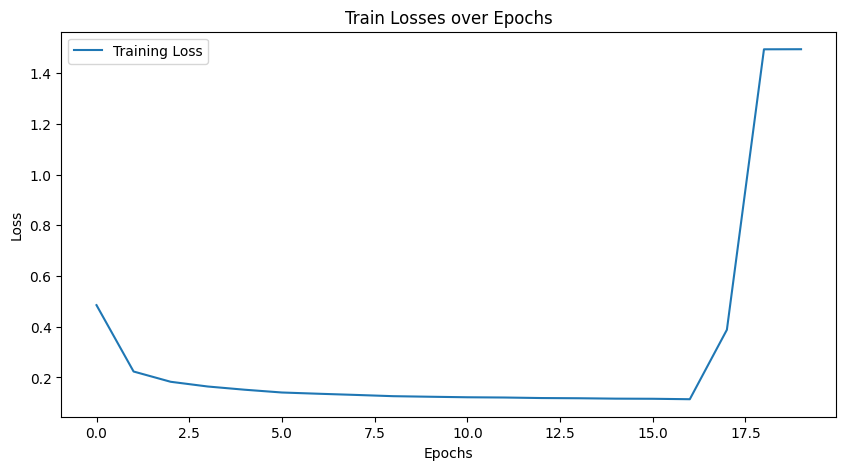

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    # plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train Losses over Epochs')
    plt.legend()
    plt.show()

  
plot_losses(train_losses, test_losses)

In [23]:
## Evaluation Code
checkpoint = torch.load('best_model.pth')
model = MyTransformer(d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward)
model.load_state_dict(checkpoint)
model.to(device)
test_loss = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss}")

Evaluating: 100%|██████████| 139/139 [00:38<00:00,  3.66it/s]

Test Loss: 0.0757004540118811
